The main function of the code is to be able to analyze the intensity of light in a video and be able to extract some sort of useful data from that, depending on what the video is of. While I am sure that there are other applications, my code is currently designed to analyze data from cepheid variable stars and differential scanning fluorimetry. A cepheid variable is a star that emits light in harmonic pulses with a contant period. Therefore, when examining a video of a star or any other object that has simple harmonic oscillations, the code attempts to find the estimated period. From what I breifly read on cepheid variables, knowing the period of the star helps astrophycists and astronomers estimate intergalactic distances. The other application, differential scanning fluorimetry or DSF, is an extremely useful technique for determining the denaturation point of a protein based on changes in fluorescence, or light. How it works, is that protein is combined with dye in a wellpate and placed within a machine called a thermocycler. A thermocycler has two functions. First it heats up the protein-dye mix, and then it records the slight changes in fluorescence. As protein is heated up, it gradually begins to unravel, or denature, which allows the dye to bind to the protein. Once the dye binds to the protein, fluorescence is emitted which is what the thermocycler measures. Generally, in order to determine the denaturation point of a protein, the relative fluorescence is plotted against temperature (in my program fluorescence is plotted against time because there is no way of knowing temperature) producing a curve the resembles a sigmoid curve. From the graph, the denaturation point can be found one of two ways: it is either the inflection point or the midpoint between the max and min extrema. In order to be more accurate, I have my program find the denaturation point using both ways and then taking the average of the two points. I would also like to add that just because I have written my code for stars and DSF does not mean it cannot analyze other videos. In fact, I have analyzed a video of a candle and of a lightbulb as well. 

The entire program consists of two file called get_video_data.py and video_data_analysis.py. These files can be called and run in an external program such as a Jupyter Notebook. The first function takes in two parameters: the video file name or path and the real life length of the video. Many of the videos that I have analyzed are actually compressed, meaning that while they may run for 10 seconds they were taken over a much longer time span, such as 1 month. The second parameter is this time span. It is a necessary parameter because without it, the program would find the period and denaturation point in seconds instead of using the appropriate units. However, if I have the actual time span, I can scale up the time values to correspond to what they were in real life. This second parameter is optional, but if used, accepts a list of two values. The first is a integer and the second is a string that gives the units, such as weeks or days. Get_video_data returns three values: a list with all the time values (the time at each frame), a list with the fluorescence at each frame, and the length of the video in seconds. These values are fed into the second function which produces a graph of fluorescence against time and the denaturation point or perid. I have two examples of the program running below. The first example shows what a graph from a video of a star might look like, while the second example simulates a graph of DSF data. Since I wasn't able to find any video of DSF or fluorescent reactions, I wrote my own quick program which creates a random data set of sigmoid data. This is to show how the program behaves differently when given different data.

The estimated period of this harmonic oscillator is 1.5244444444444456 days


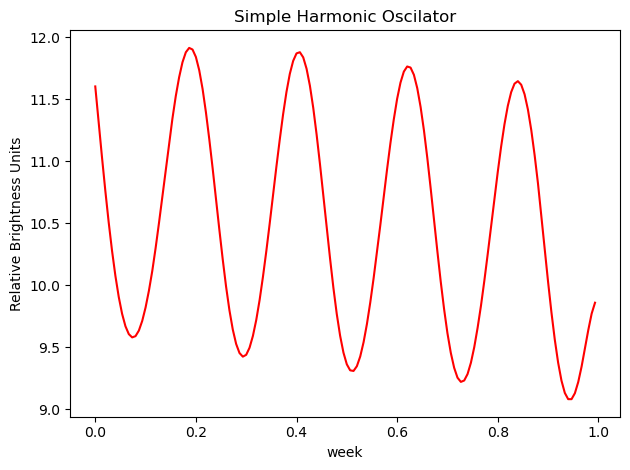

In [8]:
from get_video_data import get_video_data
from video_data_analysis import video_data_analysis

filename = r"C:\Users\coora\Python\Videos\sample9.mov" # filename or path
x_data, y_data, length = get_video_data(filename, video_timespan =[1, 'week'])
video_data_analysis(x_data, y_data, length, video_timespan =[1, 'week'])

This protein denatures at around 4.010067114093959 seconds


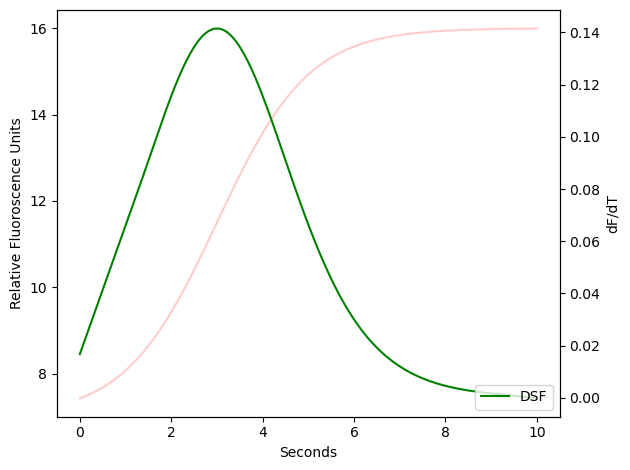

In [5]:
from get_video_data import get_video_data
from video_data_analysis import video_data_analysis
import numpy as np

def sigmoid(x, L ,x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

L = np.random.randint(low=1, high=10)
x0 = np.random.randint(low=1, high=10)
k = np.random.randint(low=1, high=2)
b = np.random.randint(low=1, high=10)
x = np.linspace(0,10,150)

x_data = x
y_data = sigmoid(x, L, x0, k, b)
length = 5.5

video_data_analysis(x_data, y_data, length)

After defining all the necessary functions, the first thing get_video_data does when it runs is read and analyze the first frame. The goal of this is to identify the brightest object in the frame and a set of coordinates that will define the bounds around that object. What I mean by bounds, is a set of x and y coordinates for a few select points located on all sides of the object. These points need to be identified so that the program knows the size of the object and how to crop each frame later in the program (I will explain why later). The first frame is run through a function called get_contour. Get_contour turns the image black and white and applies a Gaussian Blur. The Gaussian Blur averages out all neighboring point to eliminate the noise and enable the program accurately identify the brightest spot in the frame. Otherwise, the program might be thrown off by a random bright pixel. Next, using cv2.minMaxLoc, the coordinates of the brightest loci are found.

In [ ]:
def get_contour(img):
        # this function finds a string of x and y coordinates for the contour of the brightest object
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # turns image to gray
        blurred = cv2.GaussianBlur(gray, (7, 7), 0) # blurs image by averaging out all neightboring values
        # this is necessary for removing any noise 

        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(blurred) # finds location of brightest point
        # if the image isn't blurred then the brightest spot might be a random really bright pixel 
        # rather than the actual brightest region

The blurred image is then processed and a function called cv2.findContours is used to find the contours of the image. This finds contours around all the objects that the function is able to identify. Since the contour-finder isn't perfect, it can find multiples partial contours around the object of interest. These contours generally resemble thick lines around the object. Then, the program loops through all the contours found by the contour-finder and applies a box function to them which creates a box around each contour. The program then finds and creates an array containing the x and y coordinates of the 4 corners of the box. Each one of these arrays are added to a list called boxes.

In [ ]:
        edged = cv2.Canny(blurred, 50, 100)
        edged = cv2.dilate(edged, None, iterations=1)
        edged = cv2.erode(edged, None, iterations=1)
        # image preprocessing

        contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # finds the contours of the image

        boxes = []
        for c in contours: # loop over the contours individually
            box = cv2.minAreaRect(c)
            box = cv2.boxPoints(box) 
            # creates box around each contour and 
            # finds series of coordinates for each of the box's corners
            box = np.array(box, dtype="int")
            # each box is array of 4 tuples
            boxes.append(box) # adds each "box" to an array

Then the program loops through all of the boxes and checks to see which of the boxes fall in the range of the maximum loci. Since the program finds contours for all the objects in the image, this is my way of finding which of the contours actually belong to the brightest object. All contours that do not belong to the brightest object are thrown out. The x and y coordinates of the contours are then sorted into two lists: one with all the x coordinates and one with all the y coordinates. The get_contour function returns these lists. However, it is entirely possible that program is unable to find contours or none of the contours fall in the range of the brightest loci. In this case, the function will return two empty lists. 

In [ ]:
        my_box = []
        for i in boxes:
            if (i[0][0]-10 < maxLoc[0] < i[1][0]+10) and (i[1][1]-10 < maxLoc[1] < i[0][1]+10):
                my_box.append(i)
                # checks all the boxes to see if they fall in range of the loci of the brightest point
                # the x coordinates of the max loci has to be in the range of the x coordinates of the left and right bounds of the box
                # similarly the y coordinate is in the range of the y coordinates of the top and bottom of the box
        ver = []
        hor = []
        for i in range(len(my_box)):
            for num in my_box[i]:
                # separates the x and y coordinates of each box into two separate lists
                ver.append(num[0])
                hor.append(num[1])
        return ver, hor 

After the x and y coordinates of the objects boundaries are found, the entire video is now read frame by frame. Each frame is put through the crop function which takes in the frame as well as the previously found lists of x and y coordinates as parameters. Once again the brightest loci is found. Then the program checks to see if the x and y coordinate arrays are empty so it does not cause an error. As long as the arrays are not empty, the distance between the largest and smallest x loci and largest and smallest y loci is found. The distances represent the greatest possible height and width of the object. Then the object is cropped around the brightest loci, with the height and width of the object determine the extent of the crop. In the case that no bounds were found by th previous function, the image is returned gray but uncropped. The purpose of the crop is to be able to zoom in around the brightest object in the image. Some of the videos that I analyze only contained one object in the frame; however, a video of the night sky contained many stars in the frame. Without being able to zoom in around a particular star, it would have been impossible to see how the brightness of that star varies because of the amount of background interference. However, if the function cannot find objects, it is fine for it to not crop the image. For example, for DSF it may be better to not crop the image because the goal is to look at how the fluorescence of the entire wellplate varies as opposed to one particular point. One of the drawbacks of the cropping algorithm is that if the star or object of interest is not the brightest object, the program does not find it. Ideally, the program would have been able to zoom in around object that pulse with light, but this would have been a much more complex problem since the program would have had to scan all of the frames in the video to identify the object and its bounds, not just the first frame.

In [ ]:
    def crop(img, vertical_bounds, horizontal_bounds):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (7, 7), 0) # turns image gray and then blurs
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(blurred) # finds location of brightest point
        if len(vertical_bounds) > 0: # checks to see if the program was able to find contours around brightest loci
            # if no contours around the brightest loci were found, then the list will turn turn up empty

            box_height = max(vertical_bounds) - min(vertical_bounds) # determines the vertical height for the cropped image
            box_width = max(horizontal_bounds) - min(horizontal_bounds) # determines the horizontal width for the cropped image
            if (maxLoc[1] - box_height > 0) and (maxLoc[0]-box_width > 0): 
                # checks to make sure that the crop is still within the bounds of the image
                crop = gray[maxLoc[1]-box_height:maxLoc[1]+box_height, maxLoc[0]-box_width:maxLoc[0]+box_width] 
                # crops orginial image around brightest point
            else:
                crop = gray # if image is unable to be cropped, function returns original image
        else:
            crop = gray
        return crop

After each frame is cropped (or uncropped), I have a quick function find the average pixel brightness of each cropped frame. The value is added to a list called brightness_values. Additionally, as the program runs, it keeps track of how many frames there are in the video because this is needed to find the length of the video. I then load the filename and frame count into a function I made called length. This function reads the video and finds the frame per seconds (fps) using an external function. I get the length of the video in seconds by dividing the frame count by the fps. Then to find the amount of seconds that passes between each frame, the program divides the video length by the amount of frames. Using the seconds-per-frame value, the program initiates a loop and finds the amount of seconds that has passed at each frame of the video. These time values are added to a list called time_stamp. The length function returns the time values as well as the length of the video, which is necessary for scaling the video.

In [ ]:
    def length(filename, frame_count):
        time_stamp = []
        video = cv2.VideoCapture(filename)
        fps = video.get(cv2.CAP_PROP_FPS) # fnds how many frames per second in the video
        
        duration = frame_count / fps # gets duration of the video by dividing the amount of frame by frames per seconds
        seconds_per_frame = duration / frame_count # fins how many seconds passes between each frame
        
        s = 0
        for i in range(frame_count):
            time_stamp.append(s)
            s += seconds_per_frame
            # creates a list of values with the amount of seconds that have passed per frame

        return time_stamp, duration

We finally have a list of the brightness values at each frame, the seconds passed at each frame, and the length of the video. However, the seconds passed at each frame may need to be scaled to the real time length of the video. To do this, each value in the list of time value is multiplied by the first integer given by the video_timespan parameter and divided by the length of the video. 

In [ ]:
    new_time_values = []
    if video_timespan: # checks to see if the video has been compressed
        for i in time_values:
            i = (video_timespan[0] / vid_length) * i # scales the length of the video to it's duration in real time
            new_time_values.append(i)
        time_values = new_time_values # replaces old array with time values with updated values

Once the first function has run, in order to graph and analyze the data, video_data_analysis.py must be called. This function accepts all the outputs of the previous function as its parameters along with the option parameter, video_timespan. The first thing that video_data_analysis does is classify the data as being harmonic and therefore from a star, or sigmoidal DSF data. Initially, I looked into using neural networks and deep learning as a way of classifying my data. This might have worked, but deep learning models require large data sets to learn from which I did not have. I tried to write a program to simulate realistic DSF and harmonic data, but I was not able to figure out how I would add noise into the data. Instead, I came up with a much simpler way to classify the data: based on the amount of extrema. All the harmonic data that I looked at had many minimums and maximums, whereas DSF data should theoretically only have one minimum and one maximum, or even zero extrema.

The first thing the data_classifier does is apply a signal filter in order to decrease some of the noise. Then it attempts to find the number of extrema by calling my extrema function. The extrema function takes in the list of brightness_values (brightness at each frame) and the length of that list as its parameters. The function then loops over each number in the brightness_values array checking for values that are either smaller or greater than both of their neightbors. These values are added to a list local maximums or a list of local mimimums. The indexes (locations) of these maxes and mins are added to two separate lists as well.

In [ ]:
        mx_values = []
        mx_index = []
        mn_values = []
        mn_index = []
    
        # Iterating over all points to check
        # local maxima and local minima
        for i in range(1, n-1):
    
            # Condition for local minima
            if(arr[i-1] > arr[i] < arr[i + 1]):
                mn_index.append(i)
                mn_values.append(arr[i])
            # Condition for local maxima
            elif(arr[i-1] < arr[i] > arr[i + 1]):
                mx_index.append(i)
                mx_values.append(arr[i])

The program then attempts to find the absolute min and max from each list. If no extrema have been found and the lists are empty, there will be an error and the program will run an exception (more on that later). After finding the absolute extrema, the minimum is subtracted from the maximum and the difference is divided by 4. This value is defined as the threshold, meaning that the difference between any two maximum and minimum must be greater than this value. The purpose of this threshold is to reduce noise. Without it, noisy DSF data would most likely end up getting classified as harmonic star data. Once the threshold has been found, the program runs through the list of maximums and makes sure that the difference between each max and the following mimimum is greater than the threshold. The indexes of all the maximums that pass this threshold are added to a list called index. This list is applied to the list called mx_index which contains the locations of all the maximums in the original list of brightness values. Only the locations of maximums that passed the threshold are kept. This process is repeated for the minimums as well. The program returns two lists of values, one containing the locations of all of the maximums and one with the locations of all of the minimums. In the off chance that no extrema where found, the location of the brightest and diminest point are returned instead. 

In [ ]:
try: # will only run if local minimum and maximums were found

            max_mx = max(mx_values)  
            min_mn = min(mn_values)
            threshold = (max_mx - min_mn) / 4
            # gets a threshold value by subtracting the value of the greatest relative max from the smallest relative min

            count = 0
            index = []
            for i in mx_values:
                try:
                    if i - mn_values[count] > threshold:
                        index.append(count)
                    count += 1
                except IndexError:
                    pass
                # sorts through all maximum to make sure that the distance between 
                # the maximum and the next min is greater than the threshold

                # adds indices of selected maximums to a list

            mx_index = list(np.array(mx_index)[index]) # takes only the indices of the maximum that pass the threshold


            # same thing as above but with minimum
            count2 = 0
            index2 = []
            for i in mn_values:
                try:
                    if mx_values[count2] - i > threshold:
                        index2.append(count2)
                    count2 += 1
                except IndexError:
                    pass

            mn_index = list(np.array(mn_index)[index2])
        
        except ValueError: 
            mx_index.append(np.where(arr == max(arr)))
            mn_index.append(np.where(arr == min(arr)))
            # if program causes a value error because there are no relative max or min
            # the index of the greatest and lowest brightness value are added to the list

        return mx_index, mn_index

Once all of the minimum and maximum have been found, the data_classifier function checks to see is the length of each of the lists is less than two. If that is the case, the data is classified as "DSF", otherwise it is classified as "harmonic". If the data is "harmonic", then the extrema are used to find the period of oscillations. The period function loops through all of the maximums and finds the difference between them and then does the same for the minimums. Then it returns the estimated period which is the average of all of these differences.

In [ ]:
    def period(mx, mn):
    
        period_values = []

        # gets period by subtracting the times between each set of consequtive maximum

        for i in range(len(mx)-1):

            period = time_values[mx[i+1]] - time_values[mx[i]]
            # gets period by subtracting the times between each set of consequtive maximum

            period_values.append(period)
            # adds the value for each period to an array of period values
            
        for i in range(len(mx)-1):

            period = time_values[mn[i+1]] - time_values[mn[i]]
            
            period_values.append(period)
            
        average_period = sum(period_values) / len(period_values)
        # finds the average period by adding up the length of each of the periods and dividing by the amount
        
        return average_period

Before the harmonic data can be graphed and the period returned, it has to be accurately scaled with appropriate units. A new variable called units is set to equal either "seconds" or the time units that were inputed by the user. If the average period found by the period function is found to be less than 1, then the period is multiplied by a conversion factor and the units set to equal the next smallest unit. For example, if the units were initially "weeks" and the period 0.28, then the period would be multiplied by 7 and the units set equal to "days". The idea behind these conversions is that a period of "1 day" is much more compehensible than "0.28 weeks".

In [ ]:
        units = "seconds"
        if len(video_timespan) > 0:
            units = video_timespan[1]

        if oscillator_period < 1: # checks to see if the oscillator period is less than one
            if units == "weeks" or units == "week":
                oscillator_period = oscillator_period * 7
                units = "days"
            elif units == "months" or units == "month":
                oscillator_period = oscillator_period * 4
                units = "weeks"
            elif units == "days" or units == "day":
                oscillator_period = oscillator_period * 24
                units = "hours"
            elif units == "hours" or units == "hour":
                oscillator_period = oscillator_period * 60
                units = "minutes"
            elif units == "minutes" or units == "minute":
                oscillator_period = oscillator_period * 60
                units = "seconds"  
                # converts to smaller unit  

Finally the relative brightness data is plotted on the y axis and the time values are plotted on the y axis. The y axis label is set to "Relative Brightness Units" while the x axis label is whatever units were inputed by the user. The program prints out the scaled period along with the appropriate units.

In [ ]:
        fig, ax1 = plt.subplots()
        ax1.plot(time_values, brightness_smooth, color="red")
        if video_timespan:
            ax1.set_xlabel(video_timespan[1])
        else:
            ax1.set_xlabel("Seconds")
        ax1.set_ylabel("Relative Brightness Units")
        plt.title("Simple Harmonic Oscilator")
        plt.tight_layout()
                
        print("The estimated period of this harmonic oscillator is {} ".format(oscillator_period) + units)

If the data gets classified as DSF, the brightness values are put through a function called signal filter which filters out some of the noise and takes the derivative. Two y axis are initiated and the relative brightness values are graphed on the left axis and the rate of change of the brightness is graphed on the right axis. 

In [ ]:
     brightness_smooth = signal.savgol_filter(brightness_values, window_length=35, polyorder=3)
        brightness_rate = signal.savgol_filter(brightness_values, window_length=35, polyorder=2, deriv=1)
        # smooths and takes derivative
            
        fig, ax1 = plt.subplots()
        ax1.plot(time_values, brightness_smooth, color="red", alpha=0.2)
        ax1.set_xlabel("Seconds")
        ax1.set_ylabel("Relative Fluoroscence Units")
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(time_values, brightness_rate, color="green", label = "dF/dT")
        ax2.set_ylabel("dF/dT")
        plt.legend(loc='lower right')
        plt.title("DSF")
        plt.tight_layout()

The denaturation point from the DSF data is found two ways. First the time at the midpoint between the two extrema is found, and then the time at the inflection point is found. The average of these two values is returned as the denaturation point. It is returned as a print statement along with the graph.

In [ ]:
        #method 1
        mx, mn = extrema(len(brightness_smooth), brightness_smooth) # gives indices
        tm_v1 = time_values[mn[0]] + (time_values[mx[0]] - time_values[mn[0]]) / 2 

        #method 2
        mx_deriv, mn_deriv = extrema(len(brightness_rate), brightness_rate)
        tm_v2 = time_values[mx_deriv[0]] # takes location of first inflection point
            
        # finds average of both methods
        tm = (tm_v1[0] + tm_v2) / 2
        
        print("This protein denatures at around {} seconds".format(tm))

While I am quite happy with the state of my program, one thing I forgot to do is to include a scaling capability for the DSF data. At the moment, the harmonic data is capable to being scaled to the actual length of the video, but when the DSF data is graphed the units are kept as seconds no matter what the user inputed. This should technically be an easy fix on my part; the only reason I didn't implement this is that I forgot about the scaling of the DSF data until the last moment.